In [1]:
import sys
sys.path.insert(0, "../")
import rebound
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from src.utilities.constants import sec2year, rad2Deg, m2au, au2m
from src.utilities.misc import normDif

In [2]:
def invariable_inc(sim, p):
    from numpy import cross, dot, arccos
    from numpy.linalg import norm
    sim_ang_mom = sim.calculate_angular_momentum()
    p_ang_mom = cross(p.xyz, p.vxyz)

    inc = arccos(dot(sim_ang_mom, p_ang_mom)/(norm(sim_ang_mom)*norm(p_ang_mom)))
    return inc*rad2Deg

In [3]:
sa = rebound.SimulationArchive("../data/sim_archives/Flora_1Myr_mercurius.bin")

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:99: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


In [4]:
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.0f" % (sa.tmin, sa.tmax/sec2year))

Number of snapshots: 20001
Time of first and last snapshot: 0.0, 1000000


In [5]:
eccentricities = np.zeros(len(sa))
inclinations = np.zeros(len(sa))
semi_major_axis = np.zeros(len(sa))
ts = np.zeros(len(sa))
for i, sim in enumerate(sa):
    sim.move_to_com()
    ps = sim.particles
    flora_orbit = ps["Flora"].calculate_orbit(ps[0])
    eccentricities[i] = flora_orbit.e
    inclinations[i] = invariable_inc(sim, ps["Flora"])
    semi_major_axis[i] = flora_orbit.a*m2au
    ts[i] = sim.t/sec2year/1e3

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


(0.0, 1000.0)

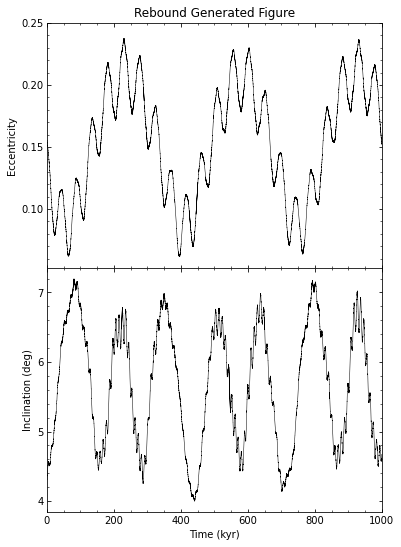

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax1.plot(ts, eccentricities, lw = .5, c = 'k')
ax1.set_ylabel("Eccentricity")
ax1.set_yticks([0.1, 0.15, 0.2, 0.25])
ax1.minorticks_on()
ax1.tick_params(which='both', direction = 'in', top=True, right=True)

ax2.minorticks_on()
ax2.tick_params(which='both', direction = 'in', top=True, right=True)
ax2.plot(ts, inclinations, lw = .5, c = 'k')
ax2.set_yticks([4, 5, 6, 7])
ax2.set_ylabel('Inclination (deg)')
ax2.set_xlabel('Time (kyr)')
plt.subplots_adjust(hspace=0)
ax1.set_title("Rebound Generated Figure")
plt.xlim(0, 1e3)
#plt.savefig('../figures/Flora_1Myr_fig2_repro.pdf')

In [7]:
max_val = 0
max_i = 0
for i, (e, inc) in enumerate(zip(eccentricities, inclinations)):
    if e/inc > max_val and ts[i] < 200:
        max_val = e/inc
        max_i = i

print(ts[max_i], eccentricities[max_i], inclinations[max_i])

181.45000778306442 0.21811988757704567 4.962752605050912


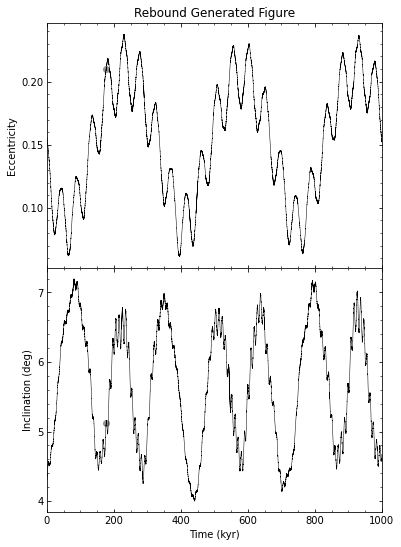

In [8]:
ax1.scatter(ts[max_i-89], eccentricities[max_i-89], c='grey', alpha = .8)
ax2.scatter(ts[max_i-89], inclinations[max_i-89], c='grey', alpha = .8)
fig

In [9]:
flora_init_1 = sa[max_i-89]
flora_init_1.t = 0
flora_init_1.save('/Users/bethclark/Projects/Flora_Family/data/sim_inits/Flora_Init_1.bin')

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [10]:
ps = flora_init_1.particles

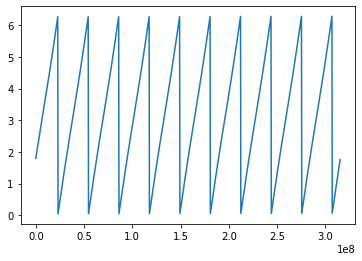

In [11]:
times = np.linspace(0, 10*sec2year, 1000)
earth_f = []
for t in times:
    flora_init_1.integrate(t)
    earth_f.append(ps["Earth"].f)
plt.plot(times, earth_f)

In [12]:
flora_init_1.status()

---------------------------------
REBOUND version:     	3.17.2
REBOUND built on:    	Jun  7 2021 17:27:05
Number of particles: 	10
Selected integrator: 	mercurius
Simulation time:     	3.1536000000000000e+08
Current timestep:    	380026.085772
---------------------------------
<rebound.particle.Particle object at 0x7fb54bba60c0, m=1.988475415966536e+30 x=66959678223716.016 y=54297816306211.27 z=-2099301296911.1753 vx=17.57465414305467 vy=1.1482611672261118 vz=-0.5681865454425822>
<rebound.particle.Particle object at 0x7fb54bba6440, m=3.3011412045397036e+23 x=66941573870236.05 y=54358086377776.37 z=-2098860414082.368 vx=-42812.182622328684 vy=-5895.201040611294 vz=7532.0195610390765>
<rebound.particle.Particle object at 0x7fb54bba60c0, m=4.86746636068329e+24 x=66864080850329.625 y=54344267490465.2 z=-2098527134421.6306 vx=-14470.559588451373 vy=-32567.625180890143 vz=376.7094981368419>
<rebound.particle.Particle object at 0x7fb54bba6440, m=6.04583029776e+24 x=67092457280059.67 y=5422772

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

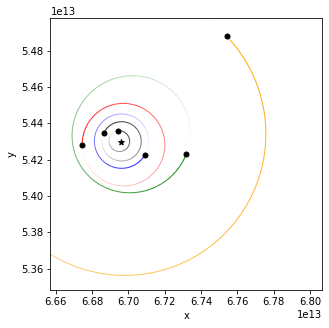

In [13]:
from src.utilities.misc import pm
xlim = pm(ps['Flora'].x, 5*au2m)
ylim = pm(ps['Flora'].y, 5*au2m)
rebound.OrbitPlot(flora_init_1, xlim=xlim, ylim=ylim, plotparticles=[1, 2, 3, 4, 5, "Flora"], color=['black', 'black', 'blue', 'red', 'orange', 'green'])

In [14]:
max_val = 0
max_i = 0
for i, (e, inc) in enumerate(zip(eccentricities, inclinations)):
    if inc/e > max_val and ts[i] < 200:
        max_val = inc/e
        max_i = i

ps = sa[max_i].particles
om = ps["Flora"].calculate_orbit(ps["Sun"]).omega*rad2Deg
while om < 90:
    max_i +=1
    ps = sa[max_i].particles
    om = ps["Flora"].calculate_orbit(ps["Sun"]).omega*rad2Deg

print('t = {:.3f}, e = {:.3f}, i = {:.3f}'.format(ts[max_i], eccentricities[max_i], inclinations[max_i]))

t = 65.400, e = 0.063, i = 6.736
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


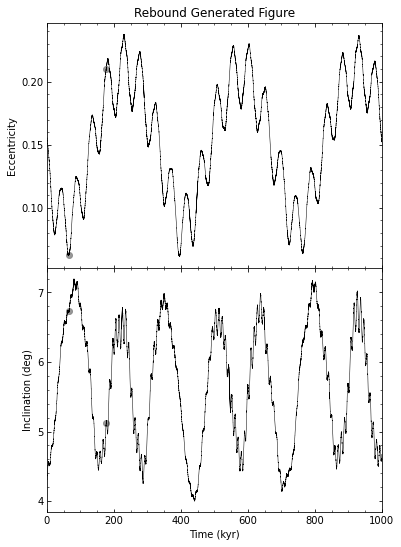

In [15]:
ax1.scatter(ts[max_i], eccentricities[max_i], c='grey', alpha = .8)
ax2.scatter(ts[max_i], inclinations[max_i], c='grey', alpha = .8)
fig

In [16]:
flora_init_2 = sa[max_i]
flora_init_2.t = 0
flora_init_2.save('/Users/bethclark/Projects/Flora_Family/data/sim_inits/Flora_Init_2.bin')

262.9685810830283

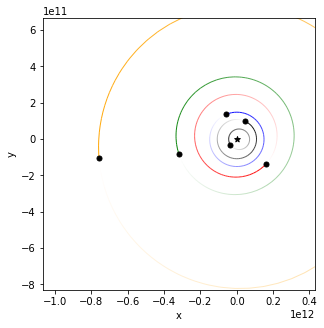

In [131]:
ps = flora_init_2.particles
xlim = pm(ps['Flora'].x, 5*au2m)
ylim = pm(ps['Flora'].y, 5*au2m)
rebound.OrbitPlot(flora_init_2, xlim=xlim, ylim=ylim, plotparticles=[1, 2, 3, 4, 5, "Flora"], color=['black', 'black', 'blue', 'red', 'orange', 'green'])
ps["Flora"].calculate_orbit(ps["Sun"]).f*rad2Deg

In [125]:
flora_init_2.move_to_com()
print(ps["Flora"])

<rebound.particle.Particle object at 0x7fc6bf5c0840, m=0.0 x=-318882934236.13727 y=-81700875901.98302 z=-4468611357.173224 vx=6103.3010322452 vy=-18901.59325946151 vz=2241.2430310169534>
